In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as vb_sparse
import VariationalBayes.ExponentialFamilies as ef

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import numpy as np
import scipy as sp
from scipy import sparse

import copy
from scipy import optimize

import os
import json

import time

import pickle

#analysis_name = 'simulated_data_small'
analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


In [2]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
pkl_file = open(pickle_output_filename, 'rb')
vb_data = pickle.load(pkl_file)

json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']

K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])



In [3]:
class LogisticGLMMLogPosterior(object):
    def __init__(
        self, glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec):

        self.glmm_par_draw = copy.deepcopy(glmm_par_draw)
        self.prior_par = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.K = x_mat.shape[1]

        assert np.min(y_g_vec) == 0
        assert np.max(y_g_vec) == self.glmm_par_draw['u'].size() - 1

    def get_log_prior(self):
        beta = self.glmm_par_draw['beta'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)
        
        cov_beta = np.zeros((self.K, self.K))
        beta_prior_info = self.prior_par['beta_prior_info'].get()
        beta_prior_mean = self.prior_par['beta_prior_mean'].get()
        log_p_beta = ef.mvn_prior(
            beta_prior_mean, beta_prior_info, beta, cov_beta)

        log_p_mu = ef.uvn_prior(
            self.prior_par['mu_prior_mean'].get(),
            self.prior_par['mu_prior_info'].get(), mu, 0.0)

        tau_prior_shape = self.prior_par['tau_prior_alpha'].get()
        tau_prior_rate = self.prior_par['tau_prior_beta'].get()
        log_p_tau = ef.gamma_prior(
            tau_prior_shape, tau_prior_rate, tau, log_tau)

        return log_p_beta + log_p_mu + log_p_tau

    def get_log_lik(self):
        beta = self.glmm_par_draw['beta'].get()
        u = self.glmm_par_draw['u'].get()
        mu = self.glmm_par_draw['mu'].get()
        tau = self.glmm_par_draw['tau'].get()
        log_tau = np.log(tau)

        log_lik = 0.

        # Log likelihood from data.
        z = u[self.y_g_vec] + np.matmul(self.x_mat, beta)
        log_lik += np.sum(self.y_vec * z - np.log1p(np.exp(z)))

        # Log likelihood from random effect terms.
        log_lik += -0.5 * tau * np.sum((mu - u) ** 2) + 0.5 * log_tau * len(u)

        return log_lik

    def get_log_posterior(self):
        return np.squeeze(
            self.get_log_lik() + \
            self.get_log_prior())




In [4]:
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=vb_data['num_gh_points'])

glmm_par_draw = vb.ModelParamsDict('GLMM Parameter Draw')
glmm_par_draw.push_param(vb.ScalarParam('mu', val=0.0))
glmm_par_draw.push_param(vb.ScalarParam('tau', val=1.0))
glmm_par_draw.push_param(vb.VectorParam('beta', K, val=np.full(K, 0.)))
glmm_par_draw.push_param(vb.VectorParam('u', NG))

log_model = LogisticGLMMLogPosterior(glmm_par_draw, prior_par, x_mat, y_vec, y_g_vec)
log_model.get_log_posterior()

-42905.344740757813

In [5]:
class LogisticGLMMBootstrap(object):
    def __init__(self, model):
        self.model = model
        self.weights = np.full(model.x_mat.shape[0], 1.0)
        self.num_gh_points = 5
        self.model.set_gh_points(self.num_gh_points)
        
        self.get_weight_obs_jacobian = autograd.grad(
            self.get_data_log_lik_term)
        
        self.obs = 0
        
    def get_data_log_lik_term(self, free_par, obs):
        self.model.glmm_par.set_free(free_par)
        return logit_glmm.get_data_log_lik_terms(
                glmm_par = self.model.glmm_par,
                x_mat = np.atleast_2d(self.model.x_mat[obs, :]),
                y_vec = np.atleast_1d(self.model.y_vec[obs]),
                y_g_vec = np.atleast_1d(self.model.y_g_vec[obs]),
                gh_x = self.model.gh_x,
                gh_w = self.model.gh_w)[0]
    
    def get_weight_jacobian_list(self, free_par):
        weight_jacobian_list = []
        #np.full((self.model.x_mat.shape[0], len(free_par)), float('nan'))
        print('Running.')
        for obs in range(self.model.x_mat.shape[0]):
            if obs % 1000 == 0:
                print('Obs {}'.format(obs))
            weight_jacobian_list.append(self.get_weight_obs_jacobian(free_par, obs))
        print('Done.')
        return weight_jacobian_list
            
    def wrap_data_log_lik_terms(self, free_par):
        self.model.glmm_par.set_free(free_par)
        return self.model.get_data_log_lik_terms()

    def optimize_with_weights(self, weights, init_par, gtol=1e-6, print_every=1):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.tr_optimize(
            init_par, num_gh_points=self.num_gh_points, gtol=gtol, print_every=print_every)   
    
    def get_model_weight_grad(self, free_par_vec, weights):
        self.model.use_weights = True
        self.model.weights = copy.deepcopy(weights)
        return self.model.objective.fun_free_grad(free_par_vec)

    
glmm_bootstrap_object = LogisticGLMMBootstrap(model)

glmm_par_free = vb_data['glmm_par_free']
elbo_hess = vb_sparse.unpack_csr_matrix(vb_data['elbo_hess_packed'])
moment_jac = vb_data['moment_jac']
print(elbo_hess.shape)

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector_from_free)


(10014, 10014)


In [51]:
base_weights = np.full(NObs, 1.0)
print(np.sum(base_weights))
base_opt = glmm_bootstrap_object.optimize_with_weights(
    weights=base_weights, init_par=glmm_par_free, gtol=1e-8)
base_free_par = base_opt.x

61895.0
Iter  0  value:  23825.6902287
Iter  1  value:  23825.6902251
Iter  2  value:  23825.6902241
Iter  3  value:  23825.689913
Iter  4  value:  23825.6898997
Iter  5  value:  23825.689899
Iter  6  value:  23825.689899
Optimization terminated successfully.
         Current function value: 23825.689899
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0


In [7]:
# Get a sparse Jacobian.
sparse_model = logit_glmm.SparseModelObjective(
    model.glmm_par, model.prior_par, model.x_mat, model.y_vec, model.y_g_vec,
    num_gh_points=model.num_gh_points, num_groups=1)

sparse_model.glmm_par.set_free(model.glmm_par.get_free())
jac_time = time.time()
weight_jacobian = sparse_model.get_sparse_weight_free_jacobian(print_every_n=100)
jac_time = time.time() - jac_time

print('Jacobian time: ', jac_time)


Group 0 of 5000
Group 100 of 5000
Group 200 of 5000
Group 300 of 5000
Group 400 of 5000
Group 500 of 5000
Group 600 of 5000
Group 700 of 5000
Group 800 of 5000
Group 900 of 5000
Group 1000 of 5000
Group 1100 of 5000
Group 1200 of 5000
Group 1300 of 5000
Group 1400 of 5000
Group 1500 of 5000
Group 1600 of 5000
Group 1700 of 5000
Group 1800 of 5000
Group 1900 of 5000
Group 2000 of 5000
Group 2100 of 5000
Group 2200 of 5000
Group 2300 of 5000
Group 2400 of 5000
Group 2500 of 5000
Group 2600 of 5000
Group 2700 of 5000
Group 2800 of 5000
Group 2900 of 5000
Group 3000 of 5000
Group 3100 of 5000
Group 3200 of 5000
Group 3300 of 5000
Group 3400 of 5000
Group 3500 of 5000
Group 3600 of 5000
Group 3700 of 5000
Group 3800 of 5000
Group 3900 of 5000
Group 4000 of 5000
Group 4100 of 5000
Group 4200 of 5000
Group 4300 of 5000
Group 4400 of 5000
Group 4500 of 5000
Group 4600 of 5000
Group 4700 of 5000
Group 4800 of 5000
Group 4900 of 5000
Jacobian time:  67.39573359489441


In [8]:
# Too bad you can't pickle sparse cholesky decomposition.

from scikits.sparse.cholmod import cholesky

inverse_time = time.time()

print('Cholesky:')
elbo_hess_chol = cholesky(elbo_hess)

print('Solve:')
param_boot_mat = -1 * elbo_hess_chol.solve_A(weight_jacobian.T)

print('Done.')

inverse_time = time.time() - inverse_time


Cholesky:
Solve:


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Done.


In [9]:
# print('To dense:')
# param_boot_mat_dense = np.asarray(param_boot_mat.todense())

# print('Multiplication:')
# moment_boot_mat = np.matmul(moment_jac, param_boot_mat_dense)

# moment_jac_sparse = sp.sparse.csr_matrix(moment_jac)
# print('Multiplication')
# moment_boot_mat = moment_jac * param_boot_mat
# print('Done')

#print(moment_boot_mat.shape)


# Moment boot mat would be huge in big applications.  Better to not even construct it.

In [53]:
# Evaluated at a linear combination of the bootstrap draw and base weights.
# Note that at the full bootstrap draw, the response is quite nonlinear.

use_jackknife = True
if use_jackknife:
    boot_draw = copy.deepcopy(base_weights)
    boot_draw[0] = 0.
else:
    boot_draw = np.random.multinomial(NObs, [1. / NObs] * NObs, size=1) - 1.0
    boot_draw = 1.0 * boot_draw + base_weights

print('Total weight (there are {} observations): {}'.format(NObs, np.sum(boot_draw)))

lr_param_diff = param_boot_mat * (np.squeeze(boot_draw) - 1.0)

# Optionally, try taking a Newton step using the Hessian.
model_weight_grad = glmm_bootstrap_object.get_model_weight_grad(
    base_free_par + lr_param_diff, boot_draw)
model_weight_grad_sp = sp.sparse.csc_matrix(np.expand_dims(model_weight_grad, axis=1))
boot_newton_step_sp = -1 * elbo_hess_chol.solve_A(model_weight_grad_sp)
boot_newton_step = np.asarray(boot_newton_step_sp)
print(np.max(np.abs(boot_newton_step)))

Total weight (there are 61895 observations): 61894.0
0.0169118821284


In [54]:
glmm_par_opt_boot = glmm_bootstrap_object.optimize_with_weights(
    init_par=base_free_par + lr_param_diff, weights=boot_draw, gtol=1e-8)
boot_free_par = glmm_par_opt_boot.x

Iter  0  value:  23824.9192467
Iter  1  value:  23824.9192426
Iter  2  value:  23824.9186615
Iter  3  value:  23824.9184073
Iter  4  value:  23824.9184064
Iter  5  value:  23824.9184064
Iter  6  value:  23824.9184064
         Current function value: 23824.918406
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 6
         Hessian evaluations: 0


True norm difference: 0.13281081798856517


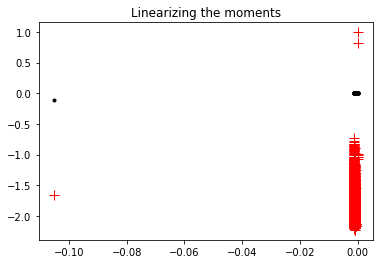

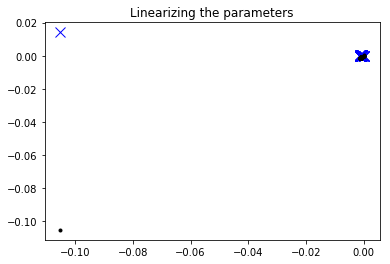

In [52]:
# The actual change in the moment vectors.
moment_vec = moment_wrapper.get_moment_vector_from_free(base_free_par)
moment_vec_boot = moment_wrapper.get_moment_vector_from_free(boot_free_par)

# Use the linear approximation for the parameters, not the moments.
moment_vec_boot_step = moment_wrapper.get_moment_vector_from_free(
    base_free_par + lr_param_diff)
boot_step_moment_diff = moment_vec_boot - moment_vec_boot_step

# The difference based on a linear approximation to the moments.
lr_moment_diff = \
    np.matmul(moment_jac, param_boot_mat * np.squeeze(boot_draw) - 1.0)

true_moment_diff = moment_vec_boot - moment_vec
print('True norm difference: {}'.format(np.linalg.norm(true_moment_diff)))

plt.figure()
plt.title('Linearizing the moments')
plt.plot(true_moment_diff, lr_moment_diff, 'r+', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')

plt.figure()
plt.title('Linearizing the parameters')
plt.plot(true_moment_diff, boot_step_moment_diff, 'bx', markersize=10)
plt.plot(true_moment_diff, true_moment_diff, 'k.')


Moment Parameters:
	e_beta:
[0 1 2 3 4]
	e_mu: [5]
	e_tau: [6]
	e_log_tau: [7]
	e_u:
[   8    9   10 ..., 5005 5006 5007]
[0, 1, 2, 3, 4, 5, 6, 7]


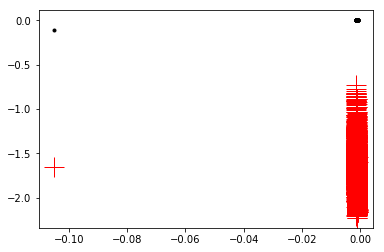

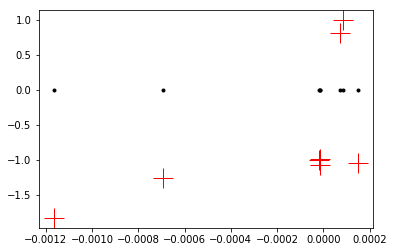

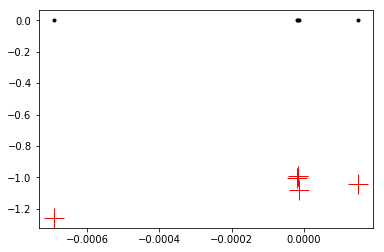

In [55]:
moment_indices = copy.deepcopy(moment_wrapper.moment_par)
moment_indices.set_vector(np.arange(0, moment_indices.vector_size()))
print(moment_indices)
u_ind = moment_indices['e_u'].get()
beta_ind = moment_indices['e_beta'].get()
non_u_ind = list(set(moment_indices.get_vector()) - set(u_ind))
print(non_u_ind)

#true_moment_diff[u_ind]

plt.figure()
plt.plot(true_moment_diff[u_ind], lr_moment_diff[u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[u_ind], true_moment_diff[u_ind], 'k.')

plt.figure()
plt.plot(true_moment_diff[non_u_ind], lr_moment_diff[non_u_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[non_u_ind], true_moment_diff[non_u_ind], 'k.')


plt.figure()
plt.plot(true_moment_diff[beta_ind], lr_moment_diff[beta_ind], 'r+', markersize=20)
plt.plot(true_moment_diff[beta_ind], true_moment_diff[beta_ind], 'k.')